Загружаю все необходимые библеотеки, которые будут использоваться, считываю данные из файлов.

In [19]:
%matplotlib inline
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

train = pd.read_csv("train_spam.csv")
test = pd.read_csv("test_spam.csv")

test.head(5)

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [2]:
train['text_type'].value_counts()

text_type
ham     4531
spam    1870
Name: count, dtype: int64

In [3]:
print(train.isnull().any())

text_type    False
text         False
dtype: bool


Загружаю стоп-слова (набор часто встречающихся слов, которые несут мало смысловой нагрузки).

In [20]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Реализую функцию подсчёта процента символов пунктуации в тексте (если они присутствуют) и функцию перевода всех символов в нижний регистр, удаления знаков пунктуации и разделения текста на токены.

In [33]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

train['body_len'] = train['text'].apply(lambda x: len(x) - x.count(" "))
train['punct%'] = train['text'].apply(lambda x: count_punct(x))

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

Разбиваю данные на обучающую и тестовую выборки.

In [22]:
X = train[['text', 'body_len', 'punct%']]
y = train['text_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

Провожу векторизацию текстовых данных.

In [36]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['text'])

tfidf_train = tfidf_vect_fit.transform(X_train['text'])
tfidf_test = tfidf_vect_fit.transform(X_test['text'])


X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True),
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True),
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,20727,20728,20729,20730,20731,20732,20733,20734,20735,20736
0,104,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Для обучения и предсказаний я использую модель случайного леса. После этого проверяю результаты на разных метриках и на матрице ошибок.

In [24]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

X_train_vect.columns = X_train_vect.columns.astype(str)
rf_model = rf.fit(X_train_vect, y_train)

X_test_vect.columns = X_test_vect.columns.astype(str)
y_pred = rf_model.predict(X_test_vect)



Precision: 0.969 / Recall: 0.822 / F1-Score: 0.89 / Accuracy: 0.943


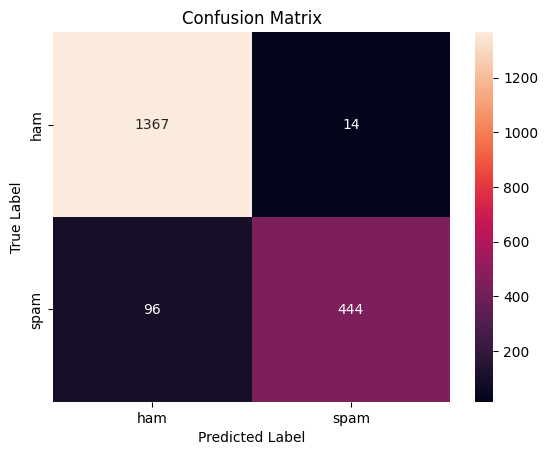

In [25]:
precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(acs(y_test,y_pred), 3)))

cm = confusion_matrix(y_test, y_pred)
class_label = ["ham", "spam"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Также, смотрю отдельно на ROC_AUC.

In [26]:
y_pred_proba = rf_model.predict_proba(X_test_vect)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(roc_auc)

0.9804241424625204


Всё то же самое для логистической регрессии.

Precision: 0.969 / Recall: 0.822 / F1-Score: 0.89 / Accuracy: 0.943


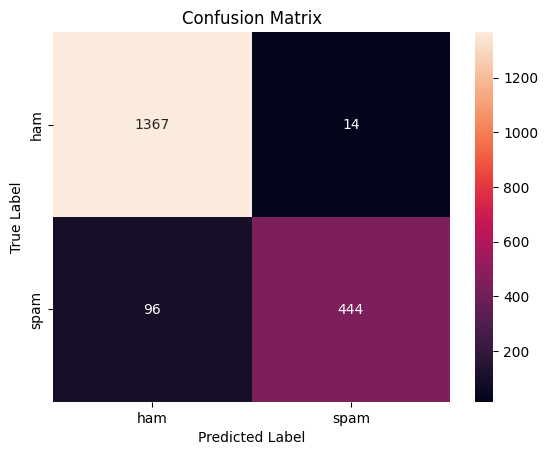

In [27]:
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train_vect, y_train)

y_pred_lr = log_reg.predict(X_test_vect)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(acs(y_test,y_pred), 3)))

cm = confusion_matrix(y_test, y_pred)
class_label = ["ham", "spam"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [28]:
y_pred_proba = log_reg.predict_proba(X_test_vect)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(roc_auc)

0.9728015125915198


В обоих случаях результаты довольно хорошие. Теперь делаю предсказания непосредствнно на тестовом файле.

In [29]:
test['body_len'] = test['text'].apply(lambda x: len(x) - x.count(" "))
test['punct%'] = test['text'].apply(lambda x: count_punct(x))

tfidf_test = tfidf_vect_fit.transform(test['text'])

X_test_final = pd.concat([test[['body_len', 'punct%']].reset_index(drop=True),
    pd.DataFrame(tfidf_test.toarray())], axis=1)

X_test_final.columns = X_test_final.columns.astype(str)

y_pred_test = rf_model.predict(X_test_final)

Создаю файл с решением simple.csv.

In [31]:
test_2 = pd.read_csv("test_spam.csv")
test_2["score"] = y_pred_test
test_2[["score", "text"]].to_csv("simple.csv", index=False)
!cat simple.csv | head

score,text
ham,j jim whitehead ejw cse ucsc edu writes j you open sourced the new components you developed for this j project so the next person who comes along won t have to j reimplement them right no need all those components already exist either in the java class libraries or from the various java jar collections most of the classes i used came from the jakarta project and apachexml but if it s any consolation my threading of them all together into a newswire server is gpl and available on sourceforge gary lawrence murphy garym teledyn com teledynamics communications inc business advantage through community software url computers are useless they can only give you answers pablo picasso
ham,original message from bitbitch magnesium net people are screaming and shouting over the political figures because they cannot be heard in any other way what are they illiterate mute what s their problem if somebody stops them from posting web pages or printing newsletters or talking on the phone 

In [32]:
test_2['score'].value_counts()

score
ham     3086
spam     984
Name: count, dtype: int64